In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
resize_layer_64 = tf.keras.Sequential([
    Resizing(64, 64),
])

In [6]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 151.38it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 142.49it/s]


In [8]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [9]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [10]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [11]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

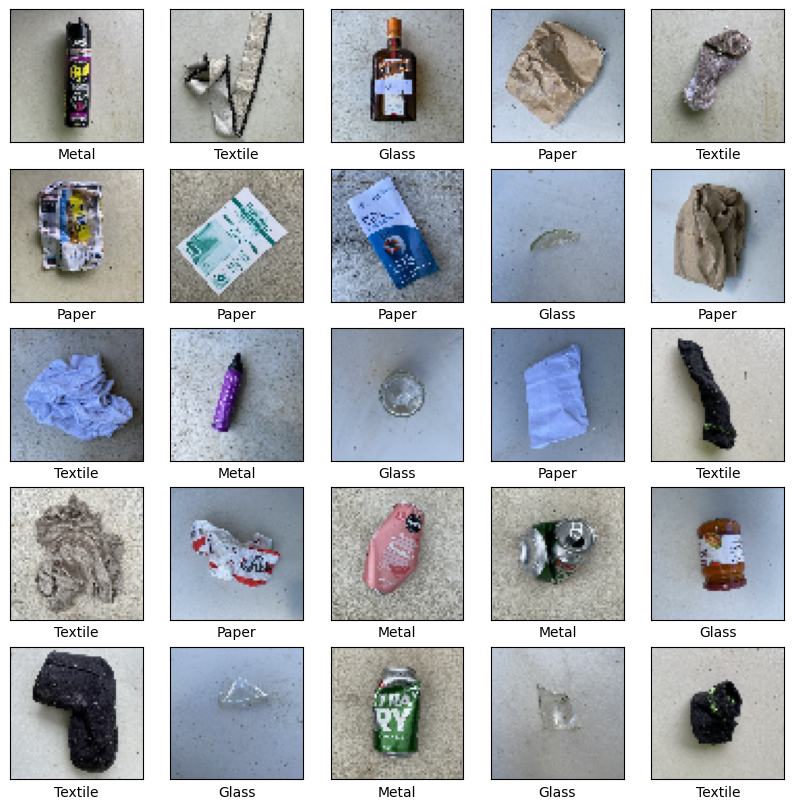

In [12]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
#Sequential Model 1
# Experience 10 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')     
])

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,444 (1.61 MB)

 Trainable params: 421,444 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
        
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')   
])

model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,756 (1.14 MB)

 Trainable params: 298,756 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
            
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,300 (919.14 KB)

 Trainable params: 235,300 (919.14 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [17]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [18]:
#Exponential decay for learning rate

def scheduler(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [19]:
# Set number of epochs

epochs = 100
batch_size = 64


In [20]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback, model_checkpoint_callback1])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)

Time model start: 2024-11-07 16:04:18.704596

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2474 - loss: 1.3986
Epoch 1: val_accuracy improved from -inf to 0.27778, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2475 - loss: 1.3979 - val_accuracy: 0.2778 - val_loss: 1.3732 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2959 - loss: 1.3753
Epoch 2: val_accuracy improved from 0.27778 to 0.38889, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2977 - loss: 1.3747 - val_accuracy: 0.3889 - val_loss: 1.3585 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6266 - loss: 0.8284 - val_accuracy: 0.5880 - val_loss: 0.9349 - learning_rate: 7.3509e-05

Epoch 38: LearningRateScheduler setting learning rate to 6.983372950344346e-05.
Epoch 38/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6758 - loss: 0.7997
Epoch 38: val_accuracy did not improve from 0.58796
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6732 - loss: 0.8031 - val_accuracy: 0.5833 - val_loss: 0.9541 - learning_rate: 6.9834e-05

Epoch 39: LearningRateScheduler setting learning rate to 6.634204510191921e-05.
Epoch 39/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6429 - loss: 0.8381
Epoch 39: val_accuracy did not improve from 0.58796
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6434 - loss: 0.8366 - val_accuracy: 0.5787 - val_loss: 0.9740 - learning_rate: 6.6342e-05

Epoch 40: LearningRateScheduler setting learning rate to 6.302494111878331e-05.
Epoch 40/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Epoch 75/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6799 - loss: 0.7492
Epoch 75: val_accuracy did not improve from 0.60185
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6789 - loss: 0.7511 - val_accuracy: 0.5926 - val_loss: 0.8978 - learning_rate: 1.0467e-05

Epoch 76: LearningRateScheduler setting learning rate to 9.944026533048599e-06.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6598 - loss: 0.7649
Epoch 76: val_accuracy did not improve from 0.60185
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6601 - loss: 0.7648 - val_accuracy: 0.5972 - val_loss: 0.9015 - learning_rate: 9.9440e-06

Epoch 77: LearningRateScheduler setting learning rate to 9.446825379200163e-06.
Epoch 77/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7092 - loss: 0.7303
Epoch 77: val_accuracy did not improve from 0.60185
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7048 - loss: 0.7380 - val_accuracy: 0.6019 - val_loss: 0.8931 - learning_rate: 

Epoch 94/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6667 - loss: 0.7675
Epoch 94: val_accuracy did not improve from 0.60185
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6690 - loss: 0.7643 - val_accuracy: 0.5880 - val_loss: 0.8920 - learning_rate: 3.9499e-06

Epoch 95: LearningRateScheduler setting learning rate to 3.752413658730802e-06.
Epoch 95/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6785 - loss: 0.7470
Epoch 95: val_accuracy did not improve from 0.60185
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6799 - loss: 0.7474 - val_accuracy: 0.5926 - val_loss: 0.8902 - learning_rate: 3.7524e-06

Epoch 96: LearningRateScheduler setting learning rate to 3.5647930189952604e-06.
Epoch 96/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6745 - loss: 0.7735
Epoch 96: val_accuracy did not improve from 0.60185
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6750 - loss: 0.7722 - val_accuracy: 0.5926 - val_loss: 0.8900 - learning_rate:

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback2])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)

Time model start: 2024-11-07 16:05:08.219386

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2485 - loss: 1.4145
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.2487 - loss: 1.4145 - val_accuracy: 0.2639 - val_loss: 1.3864 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2651 - loss: 1.4101
Epoch 2: val_accuracy improved from 0.26389 to 0.30556, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.2655 - loss: 1.4094 - val_accuracy: 0.3056 - val_loss: 1.3828 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━

Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4874 - loss: 1.1625
Epoch 19: val_accuracy did not improve from 0.41204
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4880 - loss: 1.1626 - val_accuracy: 0.3056 - val_loss: 1.3242 - learning_rate: 1.0000e-04

Epoch 20: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4948 - loss: 1.1363
Epoch 20: val_accuracy did not improve from 0.41204
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4963 - loss: 1.1353 - val_accuracy: 0.3472 - val_loss: 1.2893 - learning_rate: 1.0000e-04

Epoch 21: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4983 - loss: 1.0982
Epoch 21: val_accuracy improved from 0.41204 to 0.42130, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.5002 - loss: 1.


Epoch 56: LearningRateScheduler setting learning rate to 2.7738960125134326e-05.
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6730 - loss: 0.8269
Epoch 56: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6722 - loss: 0.8269 - val_accuracy: 0.5463 - val_loss: 1.0037 - learning_rate: 2.7739e-05

Epoch 57: LearningRateScheduler setting learning rate to 2.6352012810093584e-05.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6510 - loss: 0.8477
Epoch 57: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.6517 - loss: 0.8462 - val_accuracy: 0.5139 - val_loss: 1.0505 - learning_rate: 2.6352e-05

Epoch 58: LearningRateScheduler setting learning rate to 2.503441173757892e-05.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6470 - loss: 0.8371
Epoch 58: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - ac


Epoch 75: LearningRateScheduler setting learning rate to 1.0467396259628004e-05.
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6402 - loss: 0.8477
Epoch 75: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6419 - loss: 0.8449 - val_accuracy: 0.5417 - val_loss: 1.0164 - learning_rate: 1.0467e-05

Epoch 76: LearningRateScheduler setting learning rate to 9.944026533048599e-06.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6560 - loss: 0.8149
Epoch 76: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6567 - loss: 0.8142 - val_accuracy: 0.5417 - val_loss: 1.0080 - learning_rate: 9.9440e-06

Epoch 77: LearningRateScheduler setting learning rate to 9.446825379200163e-06.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6730 - loss: 0.8001
Epoch 77: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - acc


Epoch 94: LearningRateScheduler setting learning rate to 3.949909182665579e-06.
Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6555 - loss: 0.8224
Epoch 94: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6568 - loss: 0.8207 - val_accuracy: 0.5463 - val_loss: 0.9896 - learning_rate: 3.9499e-06

Epoch 95: LearningRateScheduler setting learning rate to 3.752413658730802e-06.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6564 - loss: 0.7980
Epoch 95: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.6573 - loss: 0.7974 - val_accuracy: 0.5463 - val_loss: 0.9943 - learning_rate: 3.7524e-06

Epoch 96: LearningRateScheduler setting learning rate to 3.5647930189952604e-06.
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6616 - loss: 0.7979
Epoch 96: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - acc

In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback3])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-07 16:08:32.844827

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2646 - loss: 1.3977
Epoch 1: val_accuracy improved from -inf to 0.42593, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.2653 - loss: 1.3976 - val_accuracy: 0.4259 - val_loss: 1.3842 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2692 - loss: 1.3864
Epoch 2: val_accuracy did not improve from 0.42593
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.2694 - loss: 1.3865 - val_accuracy: 0.4028 - val_loss: 1.3835 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2909 - loss: 1.3796
Epoch 3


Epoch 38: LearningRateScheduler setting learning rate to 6.983372950344346e-05.
Epoch 38/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5834 - loss: 0.9762
Epoch 38: val_accuracy did not improve from 0.53704
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5832 - loss: 0.9761 - val_accuracy: 0.5370 - val_loss: 1.0240 - learning_rate: 6.9834e-05

Epoch 39: LearningRateScheduler setting learning rate to 6.634204510191921e-05.
Epoch 39/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5790 - loss: 0.9470
Epoch 39: val_accuracy improved from 0.53704 to 0.54167, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5794 - loss: 0.9473 - val_accuracy: 0.5417 - val_loss: 1.0143 - learning_rate: 6.6342e-05

Epoch 40: LearningRateScheduler setting learning rate to 6.302494111878331e-05.
Epoch 40/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6110 - loss: 0.9409
Epoch 40: val_accuracy did not improve fr


Epoch 57: LearningRateScheduler setting learning rate to 2.6352012810093584e-05.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6251 - loss: 0.9081
Epoch 57: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.6251 - loss: 0.9080 - val_accuracy: 0.5139 - val_loss: 0.9922 - learning_rate: 2.6352e-05

Epoch 58: LearningRateScheduler setting learning rate to 2.503441173757892e-05.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6003 - loss: 0.9075
Epoch 58: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.6004 - loss: 0.9076 - val_accuracy: 0.5324 - val_loss: 0.9952 - learning_rate: 2.5034e-05

Epoch 59: LearningRateScheduler setting learning rate to 2.3782690459484e-05.
Epoch 59/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6385 - loss: 0.8959
Epoch 59: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accur


Epoch 76: LearningRateScheduler setting learning rate to 9.944026533048599e-06.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5951 - loss: 0.9255
Epoch 76: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.5958 - loss: 0.9243 - val_accuracy: 0.5324 - val_loss: 0.9935 - learning_rate: 9.9440e-06

Epoch 77: LearningRateScheduler setting learning rate to 9.446825379200163e-06.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6347 - loss: 0.8614
Epoch 77: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.6349 - loss: 0.8614 - val_accuracy: 0.5231 - val_loss: 0.9966 - learning_rate: 9.4468e-06

Epoch 78: LearningRateScheduler setting learning rate to 8.974483807833166e-06.
Epoch 78/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5938 - loss: 0.9045
Epoch 78: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accu


Epoch 95: LearningRateScheduler setting learning rate to 3.752413658730802e-06.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5921 - loss: 0.8906
Epoch 95: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.5935 - loss: 0.8895 - val_accuracy: 0.5231 - val_loss: 0.9936 - learning_rate: 3.7524e-06

Epoch 96: LearningRateScheduler setting learning rate to 3.5647930189952604e-06.
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6316 - loss: 0.8667
Epoch 96: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.6316 - loss: 0.8666 - val_accuracy: 0.5324 - val_loss: 0.9872 - learning_rate: 3.5648e-06

Epoch 97: LearningRateScheduler setting learning rate to 3.386553476047993e-06.
Epoch 97/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6239 - loss: 0.8658
Epoch 97: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - acc

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:2.6)')

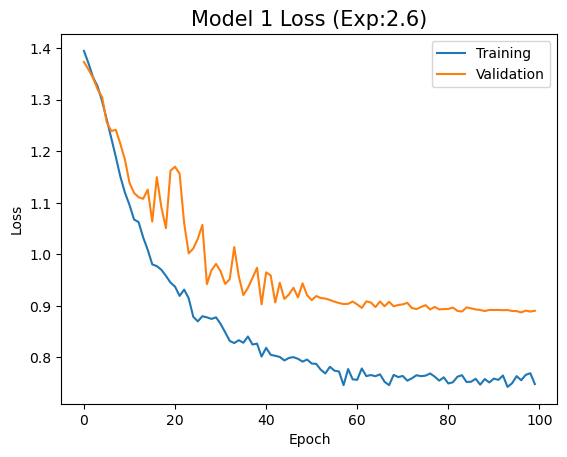

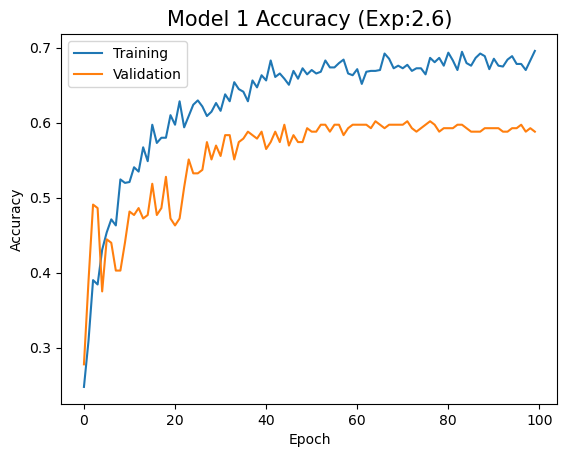

In [23]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:2.6)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:2.6)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:2.6)')

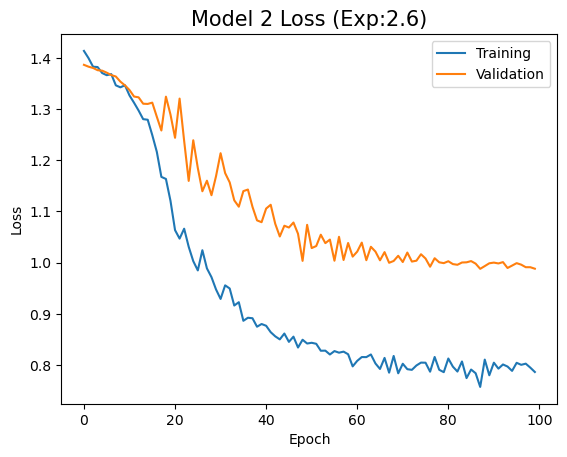

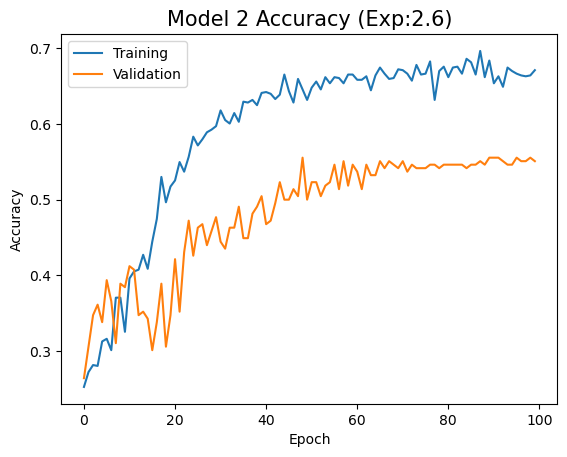

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:2.6)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:2.6)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:2.6)')

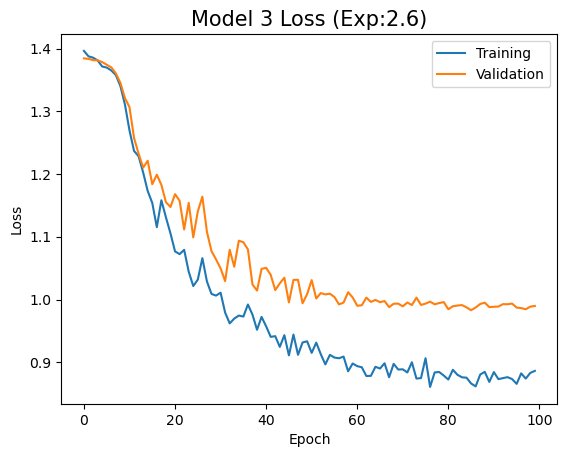

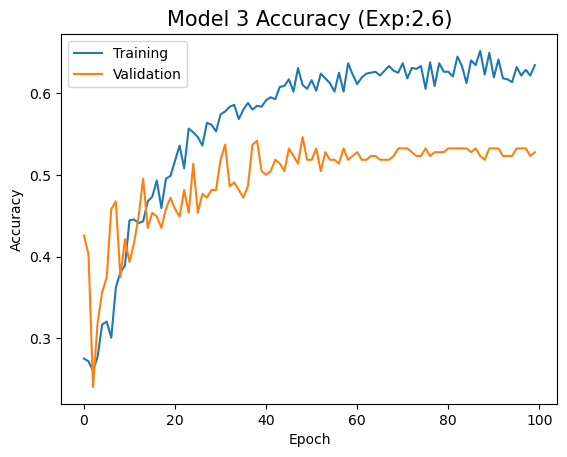

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:2.6)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:2.6)', fontsize = 15)

In [26]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6797 - loss: 0.8673 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5865 - loss: 1.0130
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5675 - loss: 1.0268


In [27]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [28]:
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [29]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


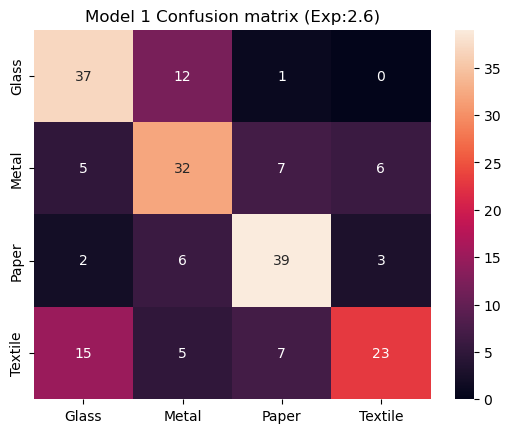

In [30]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:2.6)')
plt.show()

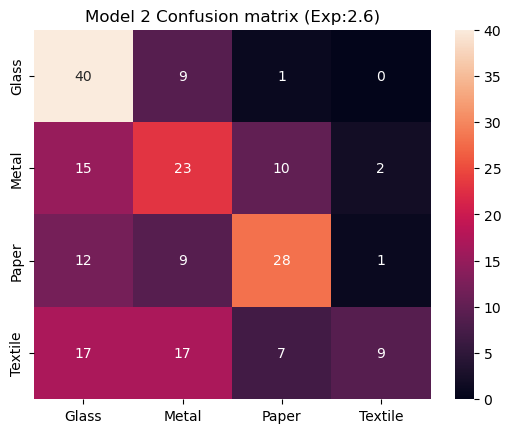

In [31]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:2.6)')
plt.show()




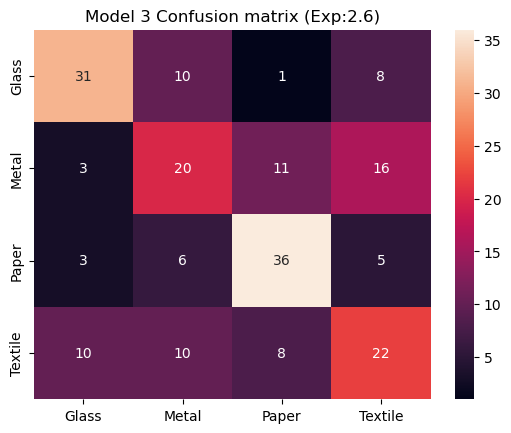

In [32]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:2.6)')
plt.show()